In [12]:
import random
import os
import shutil
from math import *
import multiprocessing
import numpy
import pylab
import matplotlib
import copy


class HiddenCube:
    
    
    def __generateHyperSphereNoise(self, coordinate_multiplier):
        
        #generate points on surface of an N-ball according to Marsaglia method
        normal_deviates = self.norm(size=(self.n_dimensions, self.dimension_size))

        radius = numpy.sqrt((normal_deviates**2).sum(axis=0))
        self.points_orig = normal_deviates/radius

        #points are now uniformly distributed along surface of unit n-ball.
        #since we want points distributed amoung interior of n-ball, multiply by uniformly random fraction
        uniform_deviates = self.unif(0,1,size=(1,self.dimension_size))
        point_radius = uniform_deviates**(1.0/self.n_dimensions)

        self.points_orig = self.points_orig * point_radius
        #points are now uniformly distributed inside unit n-ball
        #multiply by 4 because we want a large n-ball
        self.points_orig = self.points_orig * coordinate_multiplier
   
    #take an existing set of random n-ball points and add in a wire cube
    def __generateCubeSignal(self, cube_noise_factor):
        
        #unit cube corners
        cube_corners = {"x":[1,1,-1,-1,1,1,-1,-1], "y":[1,-1,-1,1,1,-1,-1,1], "z":[1,1,1,1,-1,-1,-1,-1]}

        for i in range(0, self.dimension_size):
            #random int betwen 0(inclusive) and 3(exclusive)
            # This code specifies the 3D coordinates of the unit cube
            # corners. It selects a random dimension from xyz and 
            # assigns it a uniformly random value between -1, 1
            # This creates the cube edge lines connecting the corners.
            rand_xyz = self.rand_int(0,3)
            rand_corner = self.rand_int(0,8)

            x = cube_corners["x"][rand_corner]
            y = cube_corners["y"][rand_corner]
            z = cube_corners["z"][rand_corner]

            if rand_xyz == 0:
                x = self.unif(-1,1)
            elif rand_xyz == 1:
                y = self.unif(-1,1)
            elif rand_xyz == 2:
                z = self.unif(-1,1)
            else:
                print("ERROR, this code should never be run!")

            #with noise factor at 0, this code doesnt do anything.
            #I added in a parameter for cube signal noise, but 
            #all it would do is make the cube signal more blurry.
            if(cube_noise_factor != 0):
                x += self.unif(-1,1) * cube_noise_factor
                y += self.unif(-1,1) * cube_noise_factor
                z += self.unif(-1,1) * cube_noise_factor
            
            self.points_orig[0][i] = x
            self.points_orig[1][i] = y
            self.points_orig[2][i] = z

        #now rotate just the 3D wire cube so that we dont encode the same boring cube every time.
        #this step is not essential, just adds some variety to datasets
        correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dimensions=3, rand_matrix = self.norm_matrix)
        while correct is False:
            correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dimensions=3, rand_matrix = self.norm_matrix)

        cube = self.points_orig[0:3]
        cube = cube.T
        cube = numpy.dot(cube, rotation_matrix)
        cube = cube.T
        self.points_orig[0:3] = cube
      
    
    # Create the N-dimensional simulated dataset, hiding the cube signal
        # perform a random N-dimensional rotation on the original signal dataset
        # save the rotation matrix used to create the simulated dataset for future principal angle calculations
    def __generateSimulatedDataset(self):

        #apply N-dimensional random rotation to dataset to hide 3D wire cube
        correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dimensions = self.n_dimensions, rand_matrix = self.norm_matrix)
        while correct is False:
            correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dimensions = self.n_dimensions, rand_matrix = self.norm_matrix) 

        return numpy.dot(rotation_matrix, self.points_orig), rotation_matrix

    @staticmethod
    def __principal_angle(A, B):
        #"A and B must be column-orthogonal."
        svd = numpy.linalg.svd(numpy.dot(numpy.transpose(A), B))
        return numpy.arccos(min(svd[1].min(), 1.0))

    @staticmethod
    def __randomRotationMatrix(dimensions, rand_matrix):
        
        #seed_matrix will be important later when attempting similar rotations
        seed_matrix = rand_matrix(dimensions, dimensions)
        return HiddenCube.__getRotationMatrix(dimensions, seed_matrix)

    #seed_matrix is the matrix used to create the rotation matrix that we want to make a similar version of
    @staticmethod
    def __similarRotationMatrix(dimensions, seed_matrix, rand_norm, similarity_factor):
    
        diff_matrix = rand_norm(loc=0, scale=similarity_factor, size=(dimensions,dimensions))
        new_seed_matrix = seed_matrix + diff_matrix

        return HiddenCube.__getRotationMatrix(dimensions, new_seed_matrix)
    
    @staticmethod
    def __getRotationMatrix(dimensions, seed_matrix):
        
        err = .000001 #error allowed for in verifying q is in fact a rotation matrix
        q, r = numpy.linalg.qr(seed_matrix)

        #verify Q is a rotation matrix
        det = numpy.linalg.det(q)
        #if det is not 1
        if det > 1.0 + err or det < 1.0 - err:
            #fix for a proper rotation: if det is -1, improper rotation. try to fix.
            q[0] = q[0] * -1
            # check again
            det = numpy.linalg.det(q)
            if det > 1.0 + err or det < 1.0 - err:
                #could not fix
                return False, q, seed_matrix


        inv = numpy.linalg.inv(q)
        for i in range(dimensions):
            for j in range(dimensions):
                if q.T[i][j] - inv[i][j] > err or q.T[i][j] - inv[i][j] < -err:
                    #inverse does not equal transpose, not a rotation matrix
                    return False, q, seed_matrix
        
        #q is a valid rotation matrix, seed_matrix is random matrix used in QR decomp to produce Q
        return True, q, seed_matrix

    @staticmethod        
    def __saveMatrix(filePath, matrix):
        with open(filePath, "w") as matrix_file:
            for i in range(0, len(matrix)):
                line = "{0}".format(matrix[i][0])
                for j in range(1, len(matrix[i])):
                    line = line + ",{0}".format(matrix[i][j])
                matrix_file.write(line + "\n")

        
    
    # I'd really like it if I could make these ParallelWork functions private, but I get
    # PicklingErrors when trying to pass them to the pool as private functions...
    @staticmethod
    def randRotationParallelWork(params):
        points = params[0]
        rotations = params[1]
        dims = params[2]
        sim_rotation_matrix = params[3]
        seed = params[4]
        data_dir_path = params[5]
        notebook_plot = params[6]
        
        #initialize random number generators
        if seed != -1:
            numpy.random.seed(seed)
        else:
            numpy.random.seed()

        rand_matrix = numpy.random.randn

        for i in range(0, rotations):
            correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dims, rand_matrix)
            while correct is False:
                correct, rotation_matrix, seed_matrix = HiddenCube.__randomRotationMatrix(dims, rand_matrix)

            A = sim_rotation_matrix.T[0:3].T
            B = rotation_matrix[0:2].T
            cur_principal_angle = HiddenCube.__principal_angle(A, B)

            #print out rotation_matrix, seed_matrix, image w/prin angle
            seed_matrix_filePath = os.path.join(data_dir_path, "info", "{0}_seed_matrix.txt".format(cur_principal_angle))
            HiddenCube.__saveMatrix(seed_matrix_filePath, seed_matrix)

            #I dont think we actually need to save this....
            rotation_matrix_filePath = os.path.join(data_dir_path, "info", "{0}_rotation_matrix.txt".format(cur_principal_angle))
            HiddenCube.__saveMatrix(rotation_matrix_filePath, rotation_matrix)

            rotation = numpy.dot(rotation_matrix[0:2], points)
            image_path = os.path.join(data_dir_path, "images", "{0}.png".format(cur_principal_angle))
            HiddenCube.plot2DHist(rotation, image_path, 0, 1, notebook_plot)



    def generateRandomRotations(self, rotations=100):

        rots_per_process = int(rotations/self.parallelization)
        pool = multiprocessing.Pool(processes=self.parallelization)

        param_arr = []
        for i in range(0,self.parallelization):
            
            #need to have a unique randn seed for each thread, otherwise they will generate the same rotations
            if self.randn_seed != -1:
                param_arr.append((self.points_simulated, 
                                  rots_per_process, 
                                  self.n_dimensions, 
                                  self.simulated_rotation_matrix, 
                                  self.randn_seed+i, 
                                  self.data_dir_path, 
                                  self.notebook_plotting))
            else:
                param_arr.append((self.points_simulated, 
                                  rots_per_process, 
                                  self.n_dimensions, 
                                  self.simulated_rotation_matrix, 
                                  self.randn_seed, 
                                  self.data_dir_path, 
                                  self.notebook_plotting))


        pool.map(self.randRotationParallelWork, param_arr)
        pool.close() #POOL'S CLOSED!

        pool.join()
       
    #I'd really like it if I could make these ParallelWork functions private, but I get
    # PicklingErrors when trying to pass them to the pool as private functions...
    @staticmethod
    def similarRotationParallelWork(params):
        points = params[0]
        rotations = params[1]
        dims = params[2]
        sim_rotation_matrix = params[3]
        seed_matrix = params[4]
        similarity_factor = params[5]
        seed = params[6]
        data_dir_path = params[7]
        similar_dir_path = params[8]
        notebook_plot = params[9]
        
        if seed != -1:
            numpy.random.seed(seed)
        else:
            numpy.random.seed()

        rand_norm = numpy.random.normal
            
        for i in range(0, rotations):


            correct, rotation_matrix, similar_seed_matrix = HiddenCube.__similarRotationMatrix(dims, seed_matrix, rand_norm, similarity_factor)
            while correct is False:
                correct, rotation_matrix, similar_seed_matrix = HiddenCube.__similarRotationMatrix(dims, seed_matrix, rand_norm, similarity_factor)

            #calc principal angle
            sim_rotation_matrix = numpy.array(sim_rotation_matrix)
            A = sim_rotation_matrix.T[0:3].T
            B = rotation_matrix[0:2].T
            cur_principal_angle = HiddenCube.__principal_angle(A, B)

            #print out rotation_matrix, similar_seed_matrix, image w/prin angle
            seed_info_path = os.path.join(data_dir_path, "info", "{0}_seed_matrix.txt".format(cur_principal_angle))
            HiddenCube.__saveMatrix(seed_info_path, similar_seed_matrix)

            
            #I dont think we actually need to save the rotation matrix...
            rotation_info_path = os.path.join(data_dir_path, "info", "{0}_rotation_matrix.txt".format(cur_principal_angle))
            HiddenCube.__saveMatrix(rotation_info_path, rotation_matrix)


            rotation = numpy.dot(rotation_matrix[0:2], points)

            #save image twice, once in entire dataset folder, once in similar dataset folder
            filename = os.path.join(data_dir_path, "images", "{0}.png".format(cur_principal_angle))
            sim_filename = os.path.join(similar_dir_path, "{0}.png".format(cur_principal_angle))
            
            HiddenCube.plot2DHist(rotation, filename, 0, 1, notebook_plot)
            
            shutil.copy(filename, sim_filename)
   

        
    def generateSimilarRotations(self, principal_angle_ID, rotations, similarity_factor):

        #set up directory structure
        similar_dir_path = os.path.join(self.data_dir_path, "{0}_similar_rotations".format(str(principal_angle_ID)))
        os.makedirs(similar_dir_path)
        
        #read in seed_matrix
        seed_matrix_path = os.path.join(self.data_dir_path, "info", "{0}_seed_matrix.txt".format(str(principal_angle_ID)))
        seed_matrix = []
        text = ""
        with open(seed_matrix_path, 'r') as seed_file:
            text = seed_file.read()
        text = text.split("\n")
        text.remove(text[-1]) #last element blank
        for line in text:
            elems = line.split(",")
            tmp = []
            for elem in elems:
                tmp = numpy.append(tmp, float(elem))
            seed_matrix.append(tmp)
        
        
        
        rots_per_process = int(rotations/self.parallelization)
        pool = multiprocessing.Pool(processes=self.parallelization)

        param_arr = []
        for i in range(0, self.parallelization):
            
            #need to have a unique randn seed for each thread, otherwise they will generate same rotations
            if self.randn_seed != -1:
                param_arr.append((self.points_simulated, 
                                  rots_per_process, 
                                  self.n_dimensions, 
                                  self.simulated_rotation_matrix, 
                                  seed_matrix, 
                                  similarity_factor, 
                                  self.randn_seed+i, 
                                  self.data_dir_path, 
                                  similar_dir_path,
                                  self.notebook_plotting))
            else:
                param_arr.append((self.points_simulated, 
                                  rots_per_process, 
                                  self.n_dimensions, 
                                  self.simulated_rotation_matrix, 
                                  seed_matrix, 
                                  similarity_factor, 
                                  self.randn_seed, 
                                  self.data_dir_path, 
                                  similar_dir_path,
                                  self.notebook_plotting))

        pool.map(HiddenCube.similarRotationParallelWork, param_arr)
        pool.close() #POOL'S CLOSED!

        pool.join()
    
    @staticmethod
    def plot2DHist(points_arr, name_path, x_dimension, y_dimension, notebook_plot):

        fig = pylab.figure()
        
        #add points to data at each corner, truncate data past corners.

        x = copy.deepcopy(points_arr[x_dimension])
        y = copy.deepcopy(points_arr[y_dimension])

        #truncate any data outside off -2,-2 2,2 borders
        index = []
        for i in range(0, len(x)):
            if x[i] > 2 or x[i] < -2:
                index = numpy.append(index, i)
            if y[i] > 2 or y[i] < -2:
                index = numpy.append(index, i)
                
        #TODO for some reason, 'index' is not an array of ints, but an array of [12. 14. 15.]
        # not sure why. numpy.delete complains about this
        x = numpy.delete(x, index)
        y = numpy.delete(y, index)

        #fix borders of histogram with edge points
        x = numpy.append(x, -2)
        y = numpy.append(y, -2)
        x = numpy.append(x, -2)
        y = numpy.append(y, 2)
        x = numpy.append(x, 2)
        y = numpy.append(y, -2)
        x = numpy.append(x, 2)
        y = numpy.append(y, 2)

        #pylab.axis("off")

        #fig = pylab.figure()
        dpi = fig.get_dpi()
        inches = 512.0 / dpi
        fig.set_size_inches(inches,inches)

        ax = pylab.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        pylab.hist2d(x, y, bins=100)
        pylab.set_cmap('gray')
        pylab.savefig(name_path)
        
        
        if notebook_plot:
            pylab.show()

        pylab.clf()
    
    #class variables defined here are shared between all instances of the class
    
    def __init__(self, 
                 project_directory, 
                 dataset_name = "testSet", 
                 n_dimensions = 5, 
                 dimension_size = 1500, 
                 randn_seed = -1, 
                 hypersphere_noise_multiplier = 4,
                 parallelization = 2,
                 notebook_plotting = False):
        #instance variables unique to each instance
        
        self.dataset_name = dataset_name #Specify the name of the dataset. Data will be put in a $RSVP_DATA_HOME/datasets/<name>/ directory. Directory will be wiped prior to creating dataset
        self.n_dimensions = n_dimensions #5 #Specify how many dimensions of data to produce. The first three dimensions will form coordinates for the cube, the remaining dimensions will be uniform random noise between -2 and 2
        self.dimension_size = dimension_size #1500 # data points per dimension
        self.randn_seed = randn_seed #-1 #Specify a seed for the random num generator. -1 uses current time as seed
        self.parallelization = parallelization #number of parallel threads to spawn in creating images
        self.project_directory = project_directory #'/path/to/home'  
        self.hypersphere_noise_multiplier = hypersphere_noise_multiplier
        self.notebook_plotting = notebook_plotting # is this being run in a notebook? do you want plots in notebook?
        
        #initialize random number generators
        if self.randn_seed != -1:
            numpy.random.seed(self.randn_seed)
        else:
            numpy.random.seed()

        self.norm = numpy.random.normal
        self.unif = numpy.random.uniform
        self.rand_int = numpy.random.randint
        self.norm_matrix = numpy.random.randn
        
        # points_orig is the original cube signal (dimensions 0,1,2) along with the hypersphere noise (dimensions 3,...)
        self.points_orig = []
        # points_simulated is the cube signal and hypersphere noise all randomly rotated.  This is
        # the simulated dataset because the signal (cube) is hidden by the applied rotation
        self.points_simulated = []
        self.simulated_rotation_matrix = []
        
        # Create N-dimensional original signal dataset
            # generate a hyper sphere filled with noise
            # overwrite first three dimensions with a wireframe cube
        self.__generateHyperSphereNoise(coordinate_multiplier = hypersphere_noise_multiplier)    
        self.__generateCubeSignal(cube_noise_factor = 0)
        
        # Create the N-dimensional simulated dataset, hiding the cube signal
            # perform a random N-dimensional rotation on the original signal dataset
            # save the rotation matrix used to create the simulated dataset for future principal angle calculations
        self.points_simulated, self.simulated_rotation_matrix = self.__generateSimulatedDataset()
        
        #create dataset directory structure
        self.data_dir_path = os.path.join(self.project_directory, self.dataset_name)
        self.info_dir_path = os.path.join(self.data_dir_path, "info")
        self.images_dir_path = os.path.join(self.data_dir_path, "images")
        #remove any existing dataset with the same name
        try:
            shutil.rmtree(self.data_dir_path)
            print("Deleting existing dataset with same name...")
        except FileNotFoundError:
            print("Dataset directory did not already exist, nothing to remove")
            
        #create dataset directories
        os.makedirs(self.info_dir_path) #contains metadata about images
        os.makedirs(self.images_dir_path) #contains random rotation images
        
            

Deleting existing dataset with same name...


/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:370: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:370: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


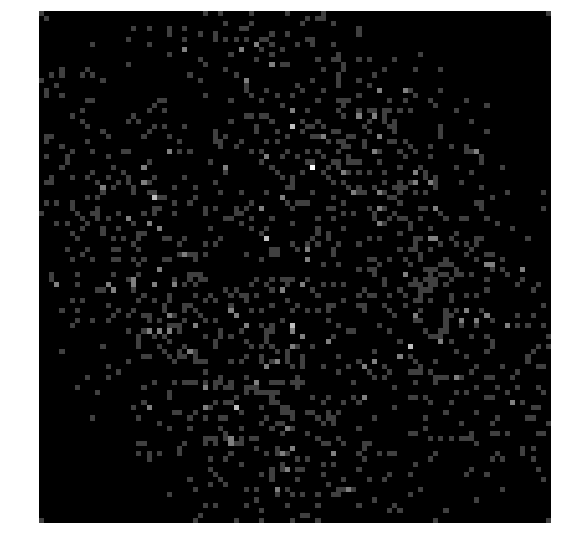

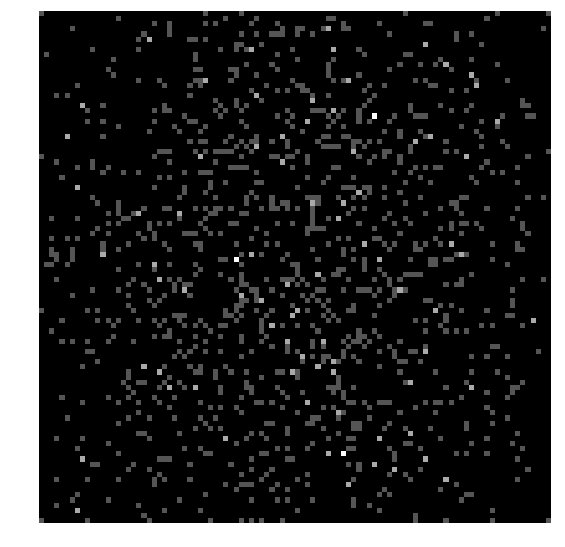

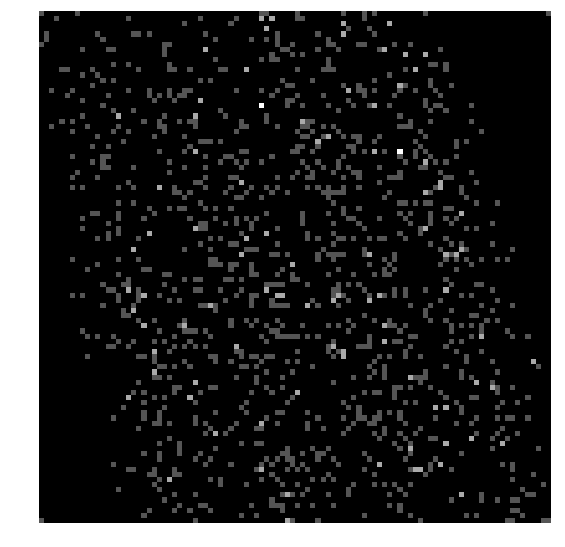

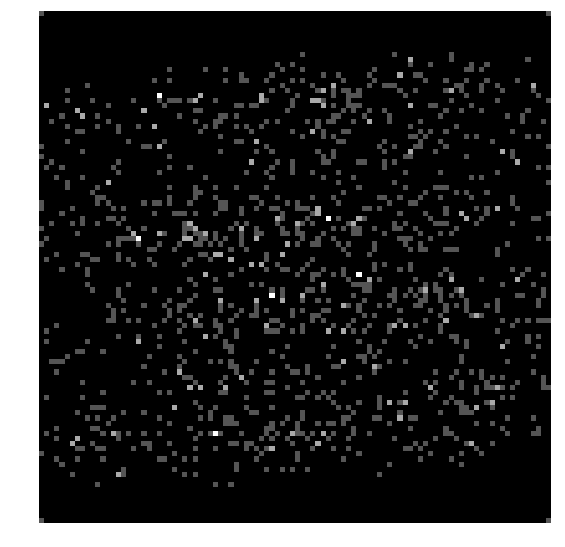

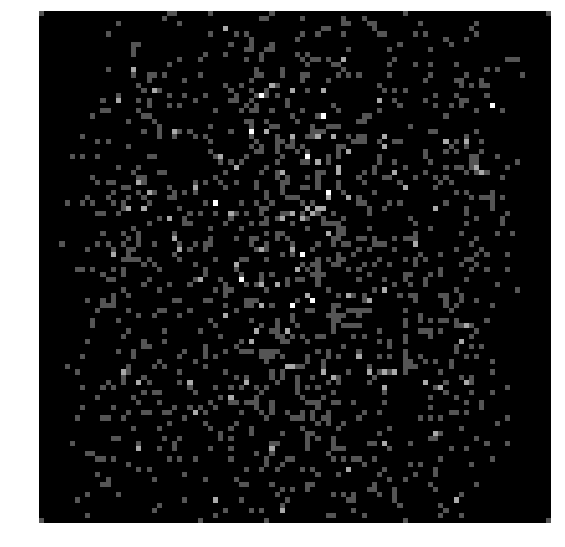

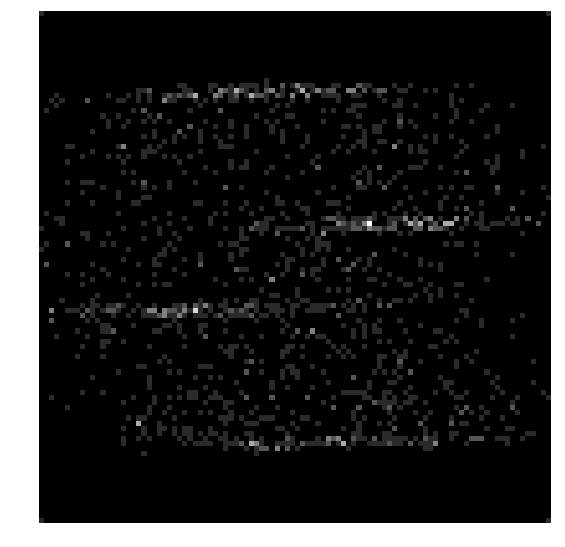

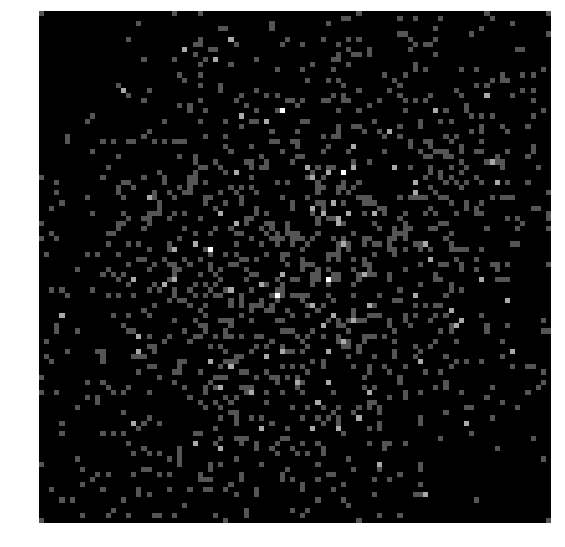

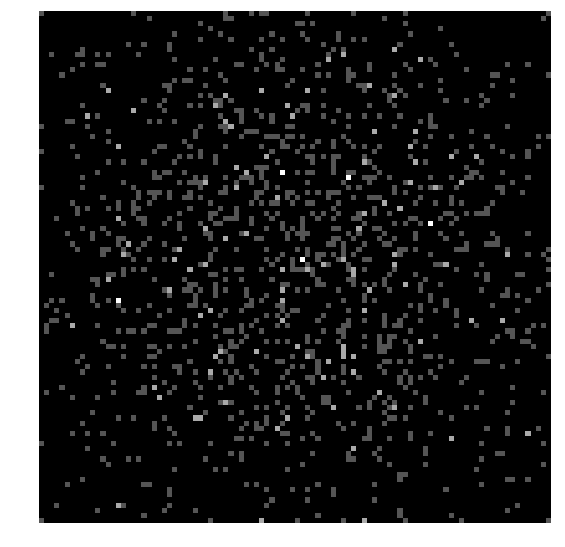

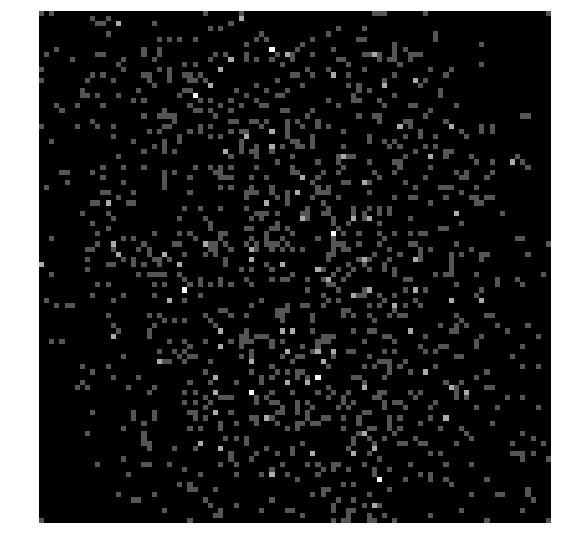

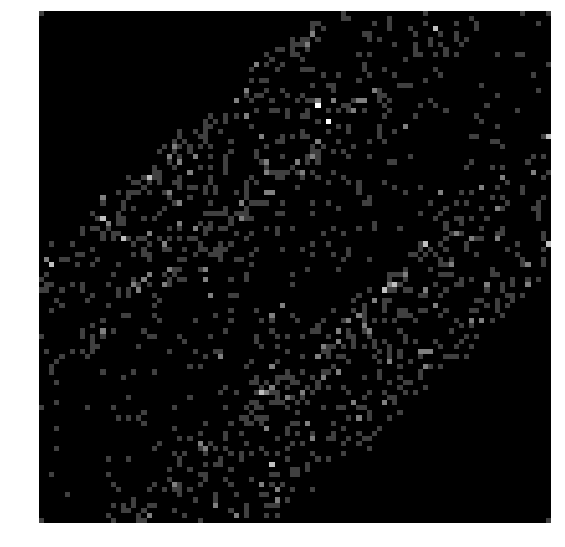

In [15]:
cube = HiddenCube(project_directory = '/home/idies/workspace/Storage/ncarey/persistent/PULSD/HiddenCubeDataset',
                  dataset_name = 'testSet',
                  n_dimensions = 5,
                  dimension_size = 1500,
                  randn_seed = -1,
                  hypersphere_noise_multiplier = 4
                  parallelization = 2,
                  notebook_plotting = True)
#cube.plot2DHist(name = 'sanityCheck_orig.png',
#                points_arr = cube.points_orig,
#                x_dimension = 0, 
#                y_dimension = 1,
#               notebook_plot = True)

#cube.plot2DHist(name = os.path.join(cube.images_dir_path, 'sanityCheck_simulated.png'),
#                points_arr = cube.points_simulated,
#                x_dimension = 0, 
#                y_dimension = 1,
#               notebook_plot = True)

cube.generateRandomRotations(rotations=10)


/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:370: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:370: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/idies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


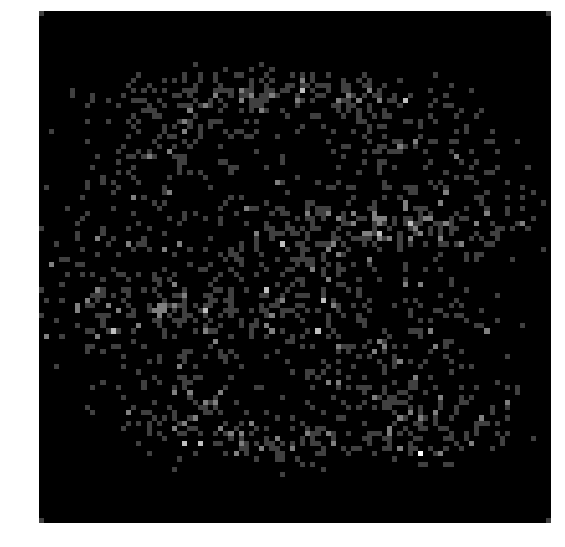

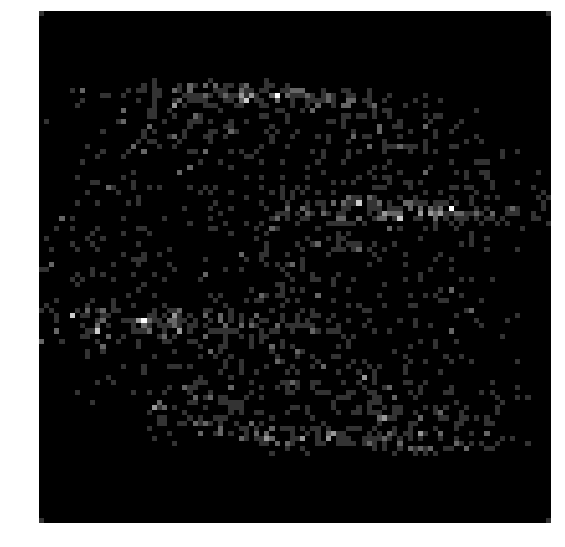

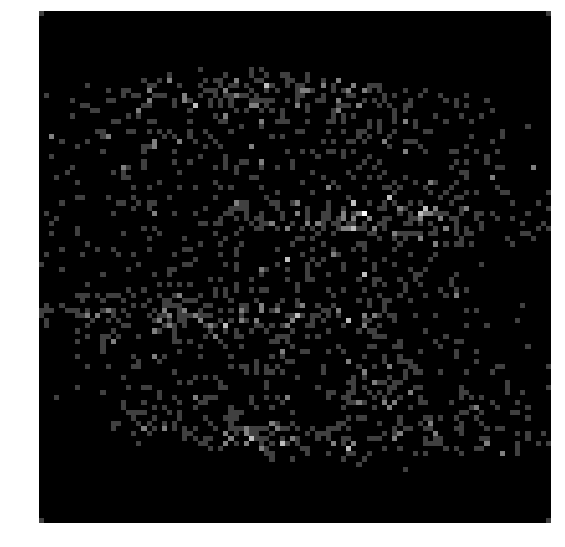

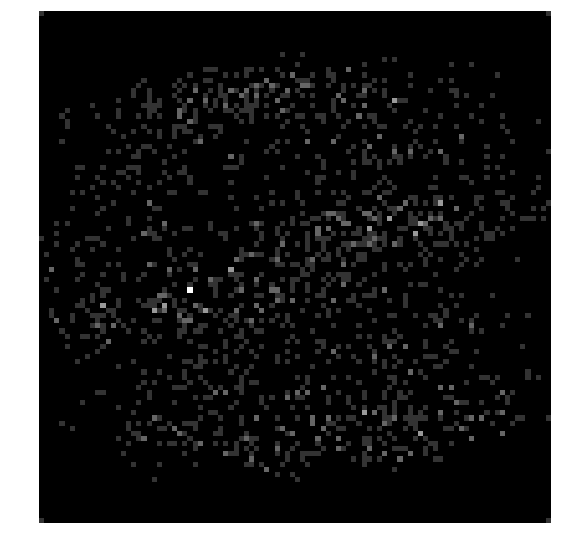

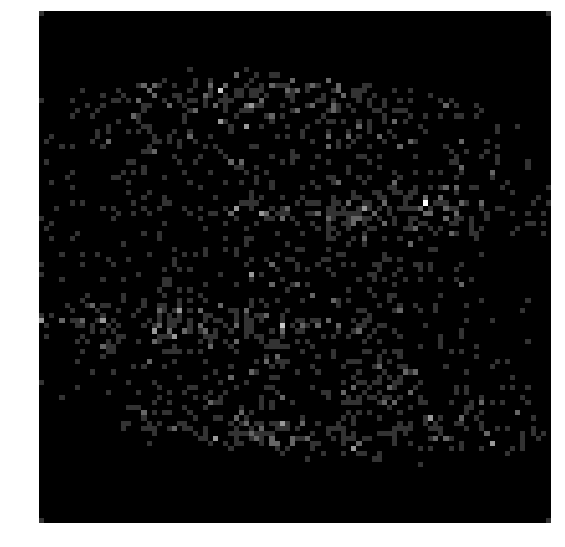

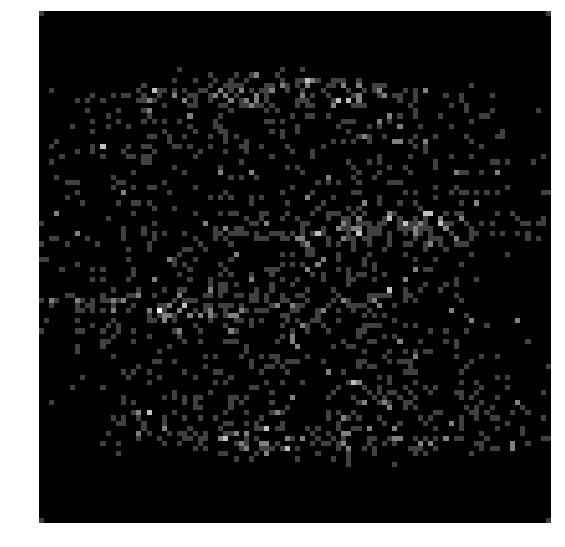

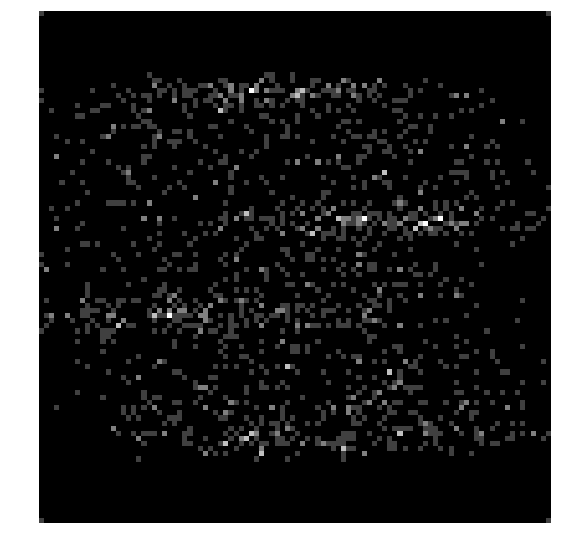

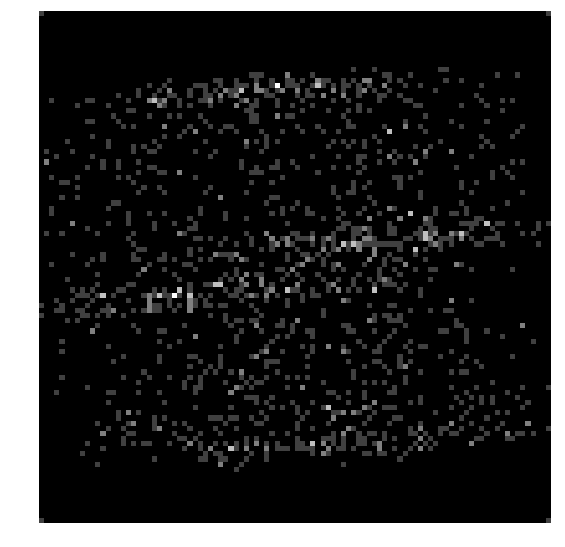

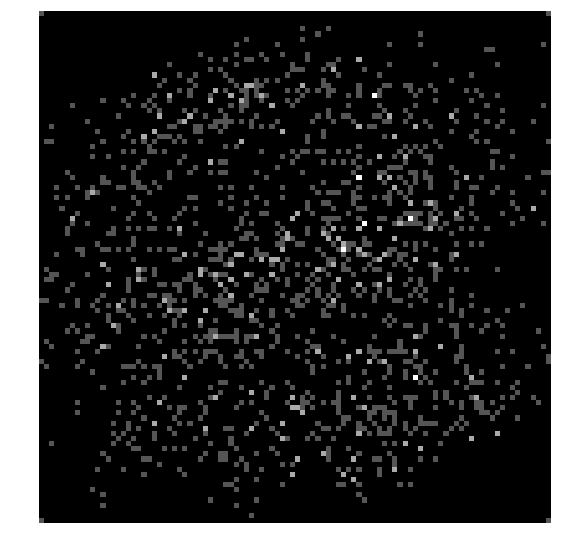

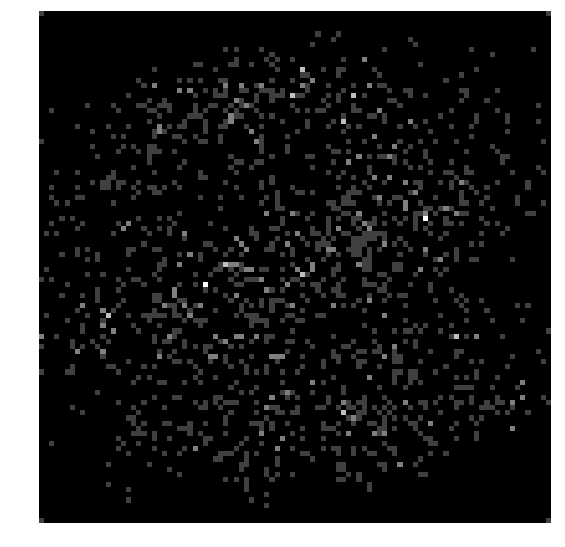

In [16]:
#paste in principal angle ID of image you want similar rotations to
cube.generateSimilarRotations(principal_angle_ID = 0.32336476134982634, 
                              rotations = 10, 
                              similarity_factor = .1)

#with a randn seed of '5', before running this, 10 images in testSet. After, 19. THere are 10 images in the similar directory. There is a missing image, investigate
#with a randn seed of -1 (current time), this doesnt seem to occur... maybe theres an identical principal angle?